In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob, os
from numpy import pi, sqrt, cos, sin, radians, arcsin
%matplotlib widget

def extract_from_txt(file_path, labels, delimiter='\n'):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {label: [] for label in labels}
    last_delimiter_index = 0
    messages = []
    for i in range(len(lines)):
        if(lines[i].startswith(delimiter)):
            messages.append(lines[last_delimiter_index:i])
            last_delimiter_index = i
    for message in messages:
        message_dict = {label: [] for label in labels}
        for label in labels:
            for line in message:
                    if(line.startswith(label)):
                        message_dict[label].append(float(line.split(':')[1]))
        full = True
        for key in message_dict:
            if(len(message_dict[key]) == 0):
                full=False
                break
        if(full):
            for label in labels:
                data_dict[label].append(message_dict[label][0])

    # for series in data_dict:
    #     print(series, len(data_dict[series]))

    df_raw = pd.DataFrame(data_dict)
    return df_raw

def remove_even_lines(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    with open(output_file_path, 'w') as file:
        for i, line in enumerate(lines):
            if i % 2 == 0:
                file.write(line)

def butterworth_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

In [42]:
# encoder_file = max(glob.glob(f"{root_dir}/{trial}/data/*encoder.txt"), key=os.path.getctime)
# force_file = max(glob.glob(f"{root_dir}/{trial}/data/*force.txt"), key=os.path.getctime)

df_encoder = pd.read_csv('spring1_encoder.csv')
df_encoder2 = pd.read_csv('spring1_encoder2.csv')

force_file = 'spring1_force.txt'
force_data_path = force_file[:-4] + '_filt.txt'
remove_even_lines(force_file, force_data_path)
df_force = extract_from_txt(
    force_data_path, 
    [
        'elapsed',
        'looptime',
        'N23', 
        'N67'
    ],
    '\n'
)
force_file2 = 'spring1_force2.txt'
force_data_path2 = force_file2[:-4] + '_filt.txt'
remove_even_lines(force_file2, force_data_path2)
df_force2 = extract_from_txt(
    force_data_path2, 
    [
        'elapsed',
        'looptime',
        'N23', 
        'N67'
    ],
    '\n'
)

df_force.loc[:,'time'] = np.cumsum(df_force['looptime']) / 1e6
df_force2.loc[:,'time'] = np.cumsum(df_force2['looptime']) / 1e6
df_encoder['time'] = df_encoder['micros']/1e6
df_encoder2['time'] = df_encoder2['micros']/1e6

df_encoder['encoder'] = (df_encoder['encoder'] + 2**13) % 2**14
df_encoder2['encoder'] = (df_encoder2['encoder'] + 2**13) % 2**14

display(df_force, df_encoder)


,elapsed,looptime,N23,N67,time
0,7057.0,662.0,0.100701,-0.126099,0.000662
1,7058.0,662.0,0.221334,-0.262724,0.001324
2,7059.0,662.0,0.251603,-0.202442,0.001986
3,7059.0,662.0,0.283005,-0.241016,0.002648
4,7060.0,662.0,0.307486,-0.163216,0.003310
...,...,...,...,...,...
157762,111485.0,662.0,15.136154,-0.567806,104.419689
157763,111485.0,662.0,15.177518,-0.581884,104.420351
157764,111486.0,661.0,15.186158,-0.527094,104.421012
157765,111487.0,661.0,15.168221,-0.435505,104.421673


,micros,encoder,time
0,6200.0,8192.0,0.006200
1,9484.0,8189.0,0.009484
2,12900.0,8193.0,0.012900
3,16208.0,8193.0,0.016208
4,19532.0,8190.0,0.019532
...,...,...,...
16812,59353580.0,8201.0,59.353580
16813,59357028.0,8200.0,59.357028
16814,59360480.0,8200.0,59.360480
16815,59363928.0,8200.0,59.363928


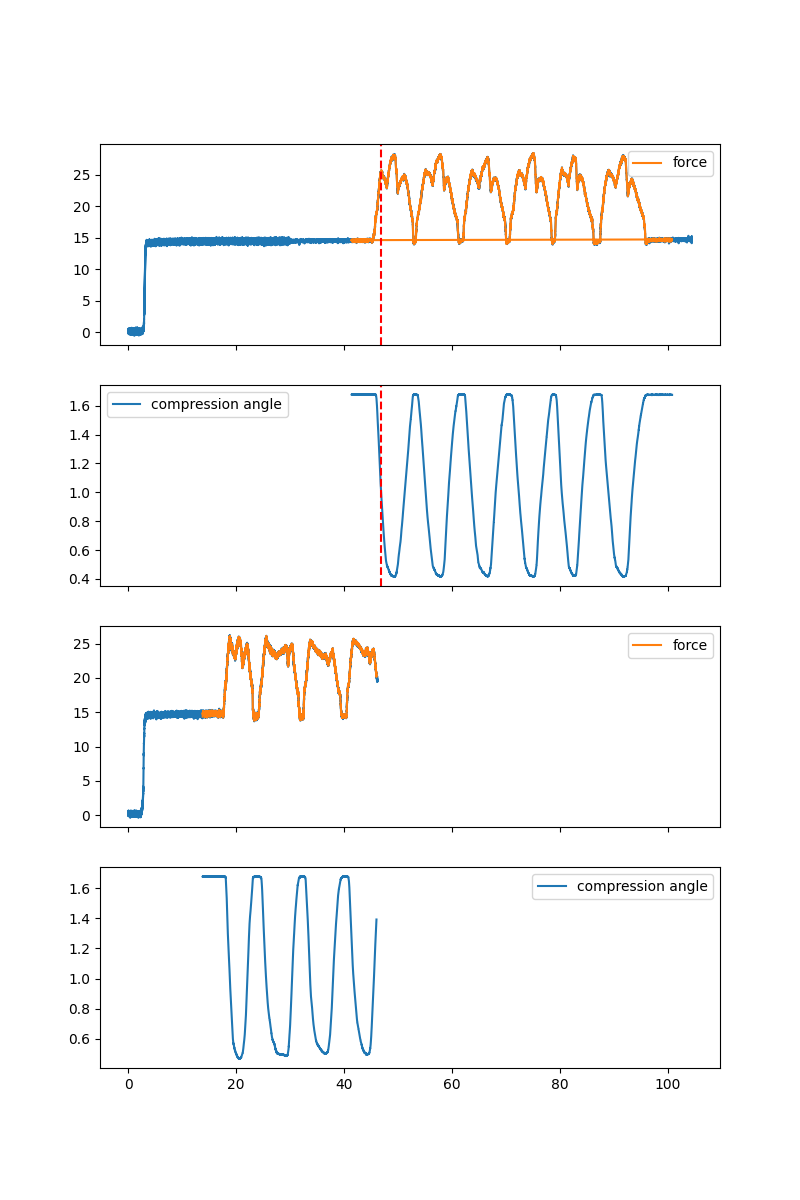

In [138]:
angle_init = radians(96.12)

df_encoder['angle'] = angle_init - radians(df_encoder['encoder']/(2**14) * 360 - 180)
df_encoder['time_adj'] = df_encoder['time'] + 41.4
df_encoder2['angle'] = angle_init - radians(df_encoder2['encoder']/(2**14) * 360 - 180)
df_encoder2['time_adj'] = df_encoder['time'] + 13.8

df_encoder2 = df_encoder2[df_encoder2['time_adj'] < 46]


from scipy.interpolate import interp1d
interpolator = interp1d(df_force['time'], df_force['N23'], fill_value="extrapolate")
df_encoder['N23_interp'] = interpolator(df_encoder['time_adj'])
interpolator2 = interp1d(df_force2['time'], df_force2['N23'], fill_value="extrapolate")
df_encoder2['N23_interp'] = interpolator2(df_encoder2['time_adj'])

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8,12))
axs[0].plot(df_force['time'], df_force['N23'])
axs[0].plot(df_encoder['time_adj'], df_encoder['N23_interp'], label='force')
axs[1].plot(df_encoder['time_adj'], df_encoder['angle'], label='compression angle')
# axs[1].legend()
axs[0].axvline(46.8, linestyle='dashed', color='red')
axs[1].axvline(46.8, linestyle='dashed', color='red')
# axs[1].axvline(46.8)

axs[2].plot(df_force2['time'], df_force2['N23'])
axs[2].plot(df_encoder2['time_adj'], df_encoder2['N23_interp'], label='force')
axs[3].plot(df_encoder2['time_adj'], df_encoder2['angle'], label='compression angle')
# axs[3].legend()

for ax in axs:
    ax.legend()




In [199]:
offset = 41.4

0.6111648473124223


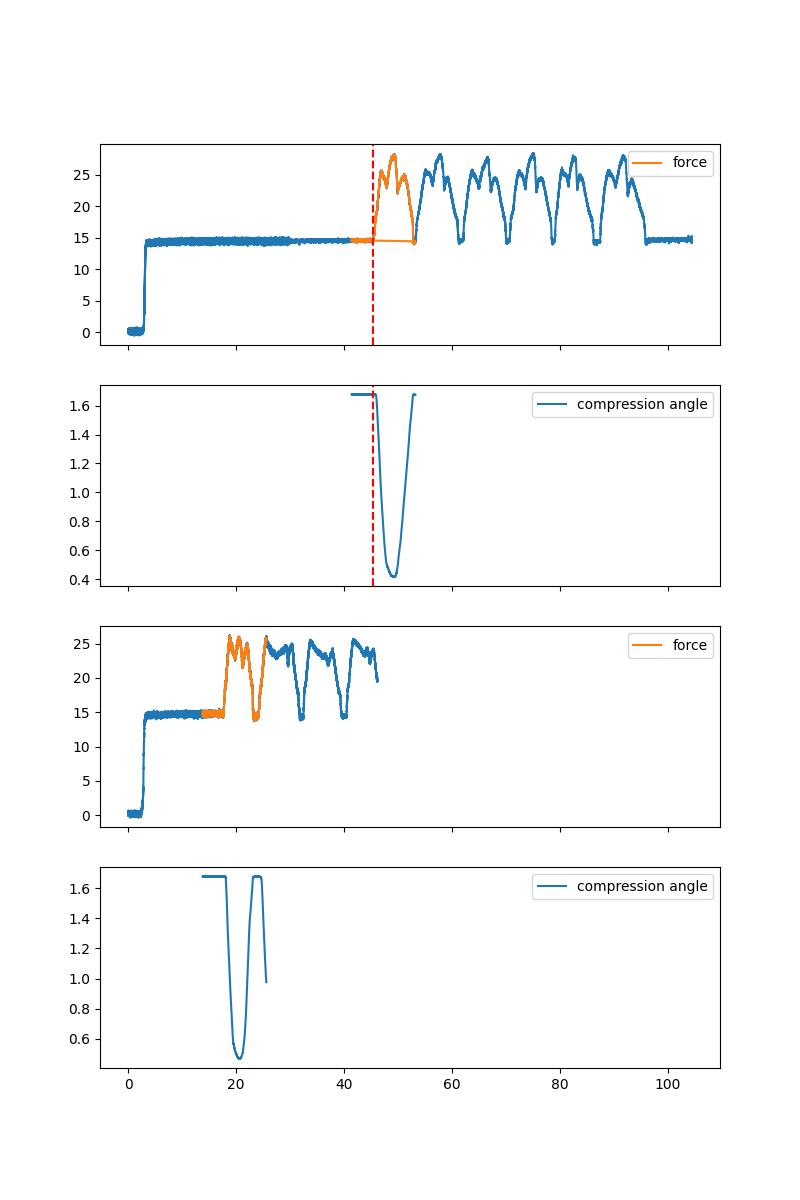

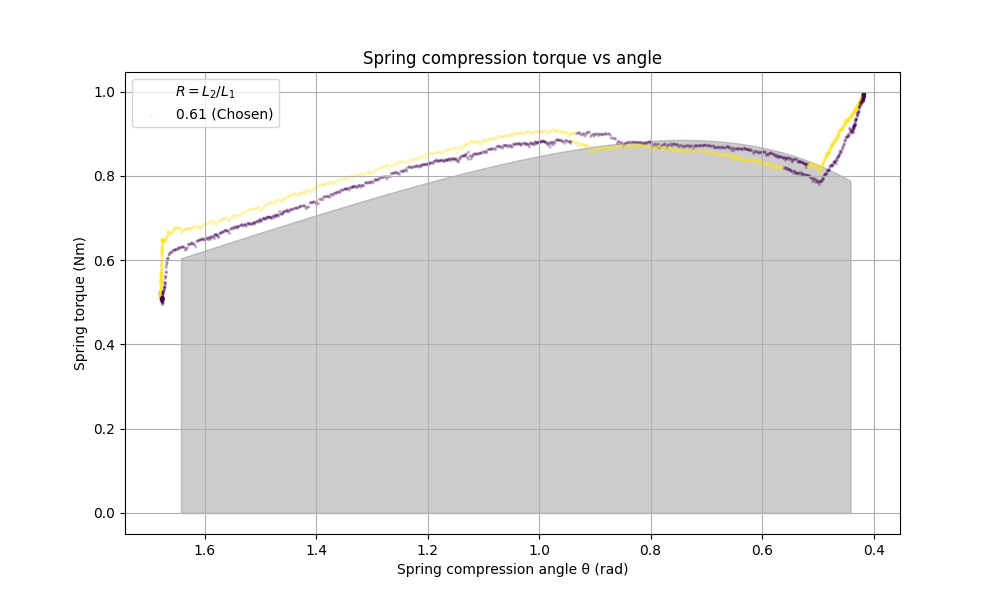

In [201]:
angle_init = radians(96.12)

df_encoder['angle'] = angle_init - radians(df_encoder['encoder']/(2**14) * 360 - 180)
df_encoder['time_adj'] = df_encoder['time'] + offset
df_encoder2['angle'] = angle_init - radians(df_encoder2['encoder']/(2**14) * 360 - 180)
df_encoder2['time_adj'] = df_encoder['time'] + 13.8

df_encoder2 = df_encoder2[df_encoder2['time_adj'] < 46]


from scipy.interpolate import interp1d
interpolator = interp1d(df_force['time'], df_force['N23'], fill_value="extrapolate")
df_encoder['N23_interp'] = interpolator(df_encoder['time_adj'])
interpolator2 = interp1d(df_force2['time'], df_force2['N23'], fill_value="extrapolate")
df_encoder2['N23_interp'] = interpolator2(df_encoder2['time_adj'])

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8,12))
axs[0].plot(df_force['time'], df_force['N23'])
axs[0].plot(df_encoder['time_adj'], df_encoder['N23_interp'], label='force')
axs[1].plot(df_encoder['time_adj'], df_encoder['angle'], label='compression angle')
# axs[1].legend()
axs[0].axvline(45.368, linestyle='dashed', color='red')
axs[1].axvline(45.368, linestyle='dashed', color='red')
# axs[1].axvline(46.8)

axs[2].plot(df_force2['time'], df_force2['N23'])
axs[2].plot(df_encoder2['time_adj'], df_encoder2['N23_interp'], label='force')
axs[3].plot(df_encoder2['time_adj'], df_encoder2['angle'], label='compression angle')
# axs[3].legend()

for ax in axs:
    ax.legend()




plt.figure(figsize=(10,6))
# plt.figure()

L1 = 0.057896
theta_start = radians(94.1)
theta_end = radians(94.1 - 68.8)
thetas = np.linspace(2.2, 0, 100)
L0 = 0.085
n_springs = 6
k = 43*n_springs
F0 = 5*n_springs

L2_real = 0.035384
R_real = L2_real/L1
print(R_real)



# L2 = 35.384
for R in np.linspace(0.3, 0.9, 6):
    L2 = R*L1
    L1_rescale = L1

    Ls = sqrt(L1_rescale**2 + L2**2 - 2*L1_rescale*L2*cos(thetas))
    Fs = k*(L0 - Ls) + F0
    # phis = arcsin()
    Ts = Fs *L2 * L2*sin(thetas)/Ls
    T_norms = Ts/max(Ts)


    color = plt.cm.hsv(R*1.5-0.5)  # Use a red-blue colormap to vary color based on R
    # plt.plot(thetas, Ts, label=f"{R:.1f}", color=color)


thetas = np.linspace(theta_start, theta_end, 50)
L2 = R_real * L1
Ls = sqrt(L1**2 + L2**2 - 2*L1*L2*cos(thetas))
Fs = k*(L0 - Ls) + F0
phis = arcsin(L2*sin(thetas)/Ls)
Ts = Fs*L2*sin(phis)
T_norms = Ts/max(Ts)
# plt.plot(thetas, Ts, label=f"0.61 (Chosen)", color='black')


x_fill = thetas[(thetas <= theta_start) & (thetas >= theta_end)]
y_fill = Ts[(thetas <= theta_start) & (thetas >= theta_end)]
plt.fill_between(x_fill, y_fill, color='gray', alpha=0.4)




# plt.plot(df_encoder['angle'], df_encoder['N23_interp'] * L2_real, label='0.61 (Chosen)', color='black')

dangle = df_encoder['N23_interp'].diff()
dangle[0] = dangle[1]
dangle = butterworth_filter(dangle, 1, 300)

plt.scatter(df_encoder['angle'], df_encoder['N23_interp'] * L2_real, label='0.61 (Chosen)', c=np.sign(dangle), alpha=0.2, s=2)
# plt.plot(df_encoder2['angle'], df_encoder2['N23_interp'] * L2_real, label='trial2')


# plt.ylim(ymin=0, ymax=50)
plt.xlabel('Spring compression angle θ (rad)')
plt.ylabel('Spring torque (Nm)')
plt.title('Spring compression torque vs angle')
plt.grid(True)
plt.gca().invert_xaxis()
plt.legend( title="$R=L_2/L_1$")


plt.savefig('spring_torque_plot.pdf', format='pdf')
plt.savefig('spring_torque_plot.png', format='png')
